### **Understanding the trajectories amongst individual**

The following cells will inspect how individual are moving across profiles between time point, and which factors are driving those trajectories.

In [1]:
# Imports
import os
import subprocess

import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

In [2]:
# Setting up data and output paths.
repository_dir = "~/code/Gagnon_BrainAge_2025/"
data_abcd = "/Volumes/T7/BrainProfilesAssociations/ABCD/"
output_folder = "/Volumes/T7/BrainAgeStudy/"

# Create output folder if it doesn't exist.
output_dir = f"{output_folder}/BAG-Trajectories/"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

# Continuous color palette.
set2 = plt.get_cmap("Set2")
color_start = set2(0)
color_end = set2(1)
custom_cmap = LinearSegmentedColormap.from_list("CustomPastel2", [color_start, color_end])
#custom_cmap = plt.get_cmap("cool")

#### **Preparing the data**

The following cells will mostly perform some formatting to match the requirements from the `lcmm` R package.

In [33]:
# Fetch the profiles data for each timepoint.
df_baseline = pd.read_excel(f"{output_folder}/merged_fcm_data.xlsx")
df_2y = pd.read_excel(f"{output_folder}/fcm_2y.xlsx")
df_4y = pd.read_excel(f"{output_folder}/fcm_4y.xlsx")

In [34]:
# Fetch the labels of the main cluster.
df_baseline["main_profile"] = np.argmax(df_baseline.iloc[:, 28:32].values, axis=1)
df_2y["main_profile"] = np.argmax(df_2y.iloc[:, 28:32].values, axis=1)
df_4y["main_profile"] = np.argmax(df_4y.iloc[:, 19:23].values, axis=1)

# Create a list containing only the subjects that are common to all timepoints.
common_subjects = list(set(df_baseline["subjectkey"]) & set(df_2y["subjectkey"]) & set(df_4y["subjectkey"]))
print(f"Number of common subjects: {len(common_subjects)}")

# Filter the dataframes to keep only the common subjects.
df_baseline = df_baseline[df_baseline["subjectkey"].isin(common_subjects)]
df_2y = df_2y[df_2y["subjectkey"].isin(common_subjects)]
df_4y = df_4y[df_4y["subjectkey"].isin(common_subjects)]

Number of common subjects: 2359


In [35]:
# Let's create groups of trajectories based on their main profile across timepoints.
# Starting by merging the dataframes to keep only the common subjects.
common_subjects = set(df_baseline["subjectkey"]).intersection(set(df_2y["subjectkey"])).intersection(set(df_4y["subjectkey"]))
df_merged = pd.merge(df_baseline[df_baseline["subjectkey"].isin(common_subjects)],
                        df_2y[df_2y["subjectkey"].isin(common_subjects)],
                        on="subjectkey", suffixes=("_baseline", "_2y"))
df_merged = pd.merge(df_merged, df_4y[df_4y["subjectkey"].isin(common_subjects)],
                        on="subjectkey", suffixes=("", "_4y"))

# Create a new column which will contain a value for each trajectory (e.g. "1-2-3" for a subject that went from profile 1 at baseline to profile 2 at 2y and profile 3 at 4y).
df_merged["trajectory"] = df_merged.apply(lambda row: f"{row['main_profile_baseline']+1}-{row['main_profile_2y']+1}-{row['main_profile']+1}", axis=1)

# Reformat subjectkey to remove "_" and add "sub-" prefix.
df_merged["subjectkey"] = df_merged["subjectkey"].str.replace("_", "", regex=False)
df_merged["subjectkey"] = "sub-" + df_merged["subjectkey"]

# Rename subjectkey to be sid.
df_merged.rename(columns={"subjectkey": "sid"}, inplace=True)

In [ ]:
# Let's load the BrainAge Gap.
df_BAG = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGaps.csv")
df_BAG_f = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGapsFemale.csv")
df_BAG_m = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGapsMale.csv")

# Rename the BAG columns (_Corrected suffix) from all models with an indicator of which model they come from.
df_BAG_f.rename(columns={"BAG_WholeBrain_Corrected": "BAG_WholeBrain_Corrected_Female",
                            "BAG_Frontal_Corrected": "BAG_Frontal_Corrected_Female",
                            "BAG_Parietal_Corrected": "BAG_Parietal_Corrected_Female",
                            "BAG_Temporal_Corrected": "BAG_Temporal_Corrected_Female",
                            "BAG_Occipital_Corrected": "BAG_Occipital_Corrected_Female",
                            "BAG_Limbic_Corrected": "BAG_Limbic_Corrected_Female",
                            "BAG_Insula_Corrected": "BAG_Insula_Corrected_Female",
                            "BAG_Subcortical_Corrected": "BAG_Subcortical_Corrected_Female"}, inplace=True)
df_BAG_m.rename(columns={"BAG_WholeBrain_Corrected": "BAG_WholeBrain_Corrected_Male",
                            "BAG_Frontal_Corrected": "BAG_Frontal_Corrected_Male",
                            "BAG_Parietal_Corrected": "BAG_Parietal_Corrected_Male",
                            "BAG_Temporal_Corrected": "BAG_Temporal_Corrected_Male",
                            "BAG_Occipital_Corrected": "BAG_Occipital_Corrected_Male",
                            "BAG_Limbic_Corrected": "BAG_Limbic_Corrected_Male",
                            "BAG_Insula_Corrected": "BAG_Insula_Corrected_Male",
                            "BAG_Subcortical_Corrected": "BAG_Subcortical_Corrected_Male"}, inplace=True)

# Keep only the sid, and BAG columns in female and male dataset.
df_BAG_f = df_BAG_f[["sid", "BAG_WholeBrain_Corrected_Female", "BAG_Frontal_Corrected_Female", "BAG_Parietal_Corrected_Female", "BAG_Temporal_Corrected_Female", "BAG_Occipital_Corrected_Female", "BAG_Limbic_Corrected_Female", "BAG_Insula_Corrected_Female", "BAG_Subcortical_Corrected_Female"]]
df_BAG_m = df_BAG_m[["sid", "BAG_WholeBrain_Corrected_Male", "BAG_Frontal_Corrected_Male", "BAG_Parietal_Corrected_Male", "BAG_Temporal_Corrected_Male", "BAG_Occipital_Corrected_Male", "BAG_Limbic_Corrected_Male", "BAG_Insula_Corrected_Male", "BAG_Subcortical_Corrected_Male"]]

# Merge the BAG data with the trajectories data.
df_merged = pd.merge(df_merged, df_BAG, on="sid", how="left")
df_merged = pd.merge(df_merged, df_BAG_f, on="sid", how="left")
df_merged = pd.merge(df_merged, df_BAG_m, on="sid", how="left")

# Remove participants with missing BAG.
df_merged.dropna(subset=["BAG_WholeBrain_Corrected"], inplace=True)

df_merged["trajectory"] = df_merged["trajectory"].astype("category")

In [38]:
# Create a new dataframe containing those columns: sid, time, BAG, m1, m2, m3, m4.
k = 0
for s, sub in enumerate(df_merged["sid"].unique()):
    for i, time in enumerate(["_baseline", "_2y", ""]):
        if i == 0:
            age = "AgeMonths_baseline"
        elif i == 1:
            age = "AgeMonths_2y"
        else:
            age = "AgeMonths"
        data = {
            "sid": sub,
            "time": i,
            "age_base": df_merged.loc[(df_merged["sid"] == sub), "AgeMonths_baseline"].values[0],
            "age": df_merged.loc[(df_merged["sid"] == sub), age].values[0],
            "sex": df_merged.loc[(df_merged["sid"] == sub), "Sex_baseline"].values[0],
            "ethnicity": df_merged.loc[(df_merged["sid"] == sub), "Ethnicity_baseline"].values[0],
            "income": df_merged.loc[(df_merged["sid"] == sub), "income_groups"].values[0],
            "education": df_merged.loc[(df_merged["sid"] == sub), "edu_groups"].values[0],
            "handedness": df_merged.loc[(df_merged["sid"] == sub), "Handedness_baseline"].values[0],
            "BAG_WholeBrain": df_merged.loc[(df_merged["sid"] == sub), "BAG_WholeBrain_Corrected"].values[0],
            "BAG_Frontal": df_merged.loc[(df_merged["sid"] == sub), "BAG_Frontal_Corrected"].values[0],
            "BAG_Parietal": df_merged.loc[(df_merged["sid"] == sub), "BAG_Parietal_Corrected"].values[0],
            "BAG_Temporal": df_merged.loc[(df_merged["sid"] == sub), "BAG_Temporal_Corrected"].values[0],
            "BAG_Occipital": df_merged.loc[(df_merged["sid"] == sub), "BAG_Occipital_Corrected"].values[0],
            "BAG_Subcortical": df_merged.loc[(df_merged["sid"] == sub), "BAG_Subcortical_Corrected"].values[0],
            "BAG_Insula": df_merged.loc[(df_merged["sid"] == sub), "BAG_Insula_Corrected"].values[0],
            "BAG_Limbic": df_merged.loc[(df_merged["sid"] == sub), "BAG_Limbic_Corrected"].values[0],
            "BAG_WholeBrain_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_WholeBrain_Corrected_Female"].values[0],
            "BAG_Frontal_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Frontal_Corrected_Female"].values[0],
            "BAG_Parietal_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Parietal_Corrected_Female"].values[0],
            "BAG_Temporal_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Temporal_Corrected_Female"].values[0],
            "BAG_Occipital_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Occipital_Corrected_Female"].values[0],
            "BAG_Subcortical_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Subcortical_Corrected_Female"].values[0],
            "BAG_Insula_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Insula_Corrected_Female"].values[0],
            "BAG_Limbic_F": df_merged.loc[(df_merged["sid"] == sub), "BAG_Limbic_Corrected_Female"].values[0],
            "BAG_WholeBrain_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_WholeBrain_Corrected_Male"].values[0],
            "BAG_Frontal_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Frontal_Corrected_Male"].values[0],
            "BAG_Parietal_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Parietal_Corrected_Male"].values[0],
            "BAG_Temporal_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Temporal_Corrected_Male"].values[0],
            "BAG_Occipital_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Occipital_Corrected_Male"].values[0],
            "BAG_Subcortical_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Subcortical_Corrected_Male"].values[0],
            "BAG_Insula_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Insula_Corrected_Male"].values[0],
            "BAG_Limbic_M": df_merged.loc[(df_merged["sid"] == sub), "BAG_Limbic_Corrected_Male"].values[0],
            "m1": df_merged.loc[(df_merged["sid"] == sub), f"Cluster #1{time}"].values[0],
            "m2": df_merged.loc[(df_merged["sid"] == sub), f"Cluster #2{time}"].values[0],
            "m3": df_merged.loc[(df_merged["sid"] == sub), f"Cluster #3{time}"].values[0],
            "m4": df_merged.loc[(df_merged["sid"] == sub), f"Cluster #4{time}"].values[0],
            "label": np.argmax([df_merged.loc[(df_merged["sid"] == sub), f"Cluster #1{time}"].values[0],
                                 df_merged.loc[(df_merged["sid"] == sub), f"Cluster #2{time}"].values[0],
                                 df_merged.loc[(df_merged["sid"] == sub), f"Cluster #3{time}"].values[0],
                                 df_merged.loc[(df_merged["sid"] == sub), f"Cluster #4{time}"].values[0]])
        }

        if k == 0:
            df_ilr = pd.DataFrame(data, index=[0])
        else:
            df_ilr = pd.concat([df_ilr, pd.DataFrame(data, index=[0])], ignore_index=True)

        k += 1


In [42]:
# Save to CSV for Rscript.
df_ilr.to_csv(f"{output_dir}/BAG_ILR_data.csv", index=False)

#### **Extracting latent class for trajectories**

The following next cells will leverage the `lcmm` R package to extract latent trajectory classes
using multivariate joint latent class mixed models. Mathematical details are described in the paper.
We will modeled up to 15 latent classes, and select the best one based on the BIC and convergence status.

In [ ]:
# ** THIS SHOULD BE RUN ON A HCP SERVER, NOT LOCALLY. **
# This takes a tremendous amount of time and memory to run.
# Please refer to the R script mlcmm.R and cmd_mlcmm.sh in the scripts/ directory.

!bash cmd_mlcmm.sh

#### **Selecting the best model.**

In [5]:
!Rscript {repository_dir}/scripts/bestModel.R -i {output_dir}/latentModels/ \
    -o {output_dir}/bestModel

Reading models from: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/
<environment: R_GlobalEnv>
Posterior probabilities for model 1:
 
Posterior classification based on longitudinal and time-to-event data: 
  class1  class2
N 883.00 1014.00
%  46.55   53.45
 
Posterior classification table: 
     --> mean of posterior probabilities in each class 
        prob1  prob2
class1 0.8946 0.1054
class2 0.0858 0.9142
 
Posterior probabilities above a threshold (%): 
         class1 class2
prob>0.7  86.07  89.84
prob>0.8  78.03  83.63
prob>0.9  66.25  73.08
 
 
Posterior classification based only on longitudinal data: 
  class1  class2
N 883.00 1014.00
%  46.55   53.45
 
[[1]]
  class1  class2
N 883.00 1014.00
%  46.55   53.45

[[2]]
        prob1  prob2
class1 0.8946 0.1054
class2 0.0858 0.9142

[[3]]
         class1 class2
prob>0.7  86.07  89.84
prob>0.8  78.03  83.63
prob>0.9  66.25  73.08

[[4]]
  class1  class2
N 883.00 1014.00
%  46.55   53.45


Posterior probabilities for model

In [42]:
# Models 2 to 6 converged, let's plot their trajectories.
for i in range(2, 7):
        print(f"Evaluating model with {i} classes.")
        subprocess.run(f"Rscript {repository_dir}/scripts/evaluateTrajectories.R -i {output_dir}BAG_ILR_data.csv \
        -o {output_dir}mod{i}classes/ -m {output_dir}latentModels/mm{i}C.rds -c {i} \
        -s sid -n 4 -x 200", shell=True, )

Evaluating model with 2 classes.



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/mod2classes/
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/latentModels/mm2C.rds
Loading data...
Number of classes in the model: 2
Updating models...
Predicting trajectories...
Predicted trajectories saved to CSV.


Evaluating model with 3 classes.



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/mod3classes/
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Predicting trajectories...
Predicted trajectories saved to CSV.


Evaluating model with 4 classes.



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/mod4classes/
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/latentModels/mm4C.rds
Loading data...
Number of classes in the model: 4
Updating models...
Predicting trajectories...
Predicted trajectories saved to CSV.


Evaluating model with 5 classes.



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/mod5classes/
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/latentModels/mm5C.rds
Loading data...
Number of classes in the model: 5
Updating models...
Predicting trajectories...
Predicted trajectories saved to CSV.


Evaluating model with 6 classes.



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/mod6classes/
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories/latentModels/mm6C.rds
Loading data...
Number of classes in the model: 6
Updating models...
Predicting trajectories...
Predicted trajectories saved to CSV.


In [4]:
# Load up the predicted values from the model with 3 classes
pred_df = pd.read_csv(f"{output_dir}/mod3classes/predicted_trajectories.csv")

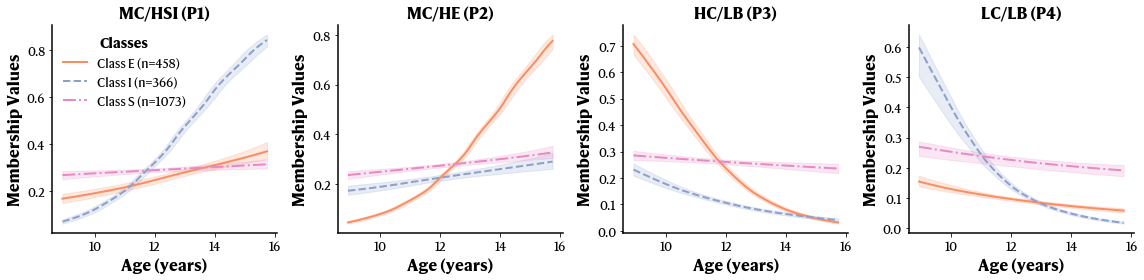

In [12]:
# Plot as a single row the trajectories for the model with 3 classes with CI. 
# Simple list of 6 line styles.
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1))]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=False)
for k, label in enumerate(["MC/HSI (P1)", "MC/HE (P2)", "HC/LB (P3)", "LC/LB (P4)"]):
    for i in range(1, 4):
        # Get column name based on k
        col_name = f"Ypred_50_class{i}" if k == 0 else f"Ypred_50_class{i}.{k}"
        ax[k].plot(pred_df['age'] / 12, pred_df[col_name], label=f'Class {"E (n=458)" if i == 1 else "I (n=366)" if i == 2 else "S (n=1073)"}', color=cmap[i], linewidth=2, linestyle=line_styles[i-1])
        # Use the precomputed CI values and fill between them.
        col_name2_5 = f"Ypred_2.5_class{i}" if k == 0 else f"Ypred_2.5_class{i}.{k}"
        col_name97_5 = f"Ypred_97.5_class{i}" if k == 0 else f"Ypred_97.5_class{i}.{k}"
        ax[k].fill_between(pred_df['age'] / 12, pred_df[col_name2_5], pred_df[col_name97_5], color=cmap[i], alpha=0.2)
    ax[k].set_xlabel('Age (years)', fontsize=16, fontweight='bold')
    ax[k].set_title(f"{label}", fontsize=16, fontweight='bold')
    ax[k].tick_params(axis='both', which='major', labelsize=12)
    ax[k].set_ylabel('Membership Values', fontsize=16, fontweight='bold')
    if k != 0:
        ax[k].legend().set_visible(False)
    else:
        ax[k].legend(title='Classes', fontsize=12, title_fontproperties={'weight':'bold', 'size': 14}, frameon=False)

    # Fix the spines and ticks.
    ax[k].spines[['top', 'right']].set_visible(False)
    ax[k].spines[['left', 'bottom']].set_linewidth(1.5)

plt.tight_layout()
plt.savefig(f"{output_dir}/mod6classes/6-class-trajectories.png", dpi=300)


#### **Assessing external variables effect on trajectories**

The following next cells will perform secondary models for predictors of latent class membership.

In [43]:
# Iterate over the regions, and run the Rscript for predictors of latent class membership.
# ** This is a long running process, go get some coffee. **
if not os.path.exists(f"{output_dir}/trajectoryPredictors/"):
    os.makedirs(f"{output_dir}/trajectoryPredictors/")

for region in ["BAG_WholeBrain", "BAG_Frontal", "BAG_Parietal", "BAG_Temporal", "BAG_Occipital", "BAG_Limbic", "BAG_Insula", "BAG_Subcortical"]:
    subprocess.run(f"Rscript {repository_dir}/scripts/trajectoryPredictors.R -i {output_dir}/BAG_ILR_data.csv \
        -o {output_dir}/trajectoryPredictors/{region}.csv -m {output_dir}/latentModels/mm3C.rds \
        -c sex,{region},handedness,ethnicity,income,education \
        -s sid -p twoStageJoint -n 4", shell=True)

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictors/BAG_WholeBrain.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: sex, BAG_WholeBrain, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictors/BAG_Frontal.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: sex, BAG_Frontal, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG

In [44]:
# Iterate over the same regions, but this time for female subjects only.
# ** This is a long running process, go get some coffee. **
if not os.path.exists(f"{output_dir}/trajectoryPredictorsFemale/"):
    os.makedirs(f"{output_dir}/trajectoryPredictorsFemale/")

for region in ["BAG_WholeBrain_F", "BAG_Frontal_F", "BAG_Parietal_F", "BAG_Temporal_F", "BAG_Occipital_F", "BAG_Limbic_F", "BAG_Insula_F", "BAG_Subcortical_F"]:
    subprocess.run(f"Rscript {repository_dir}/scripts/trajectoryPredictors.R -i {output_dir}/BAG_ILR_data.csv \
        -o {output_dir}/trajectoryPredictorsFemale/{region}.csv -m {output_dir}/latentModels/mm3C.rds \
        -c {region},handedness,ethnicity,income,education \
        -s sid -p twoStageJoint -n 4", shell=True)

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictorsFemale/BAG_WholeBrain_F.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: BAG_WholeBrain_F, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictorsFemale/BAG_Frontal_F.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: BAG_Frontal_F, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAge

In [45]:
# Iterate over the same regions, but this time for male subjects only.
# ** This is a long running process, go get some coffee. **
if not os.path.exists(f"{output_dir}/trajectoryPredictorsMale/"):
    os.makedirs(f"{output_dir}/trajectoryPredictorsMale/")

for region in ["BAG_WholeBrain_M", "BAG_Frontal_M", "BAG_Parietal_M", "BAG_Temporal_M", "BAG_Occipital_M", "BAG_Limbic_M", "BAG_Insula_M", "BAG_Subcortical_M"]:
    subprocess.run(f"Rscript {repository_dir}/scripts/trajectoryPredictors.R -i {output_dir}/BAG_ILR_data.csv \
        -o {output_dir}/trajectoryPredictorsMale/{region}.csv -m {output_dir}/latentModels/mm3C.rds \
        -c {region},handedness,ethnicity,income,education \
        -s sid -p twoStageJoint -n 4", shell=True) 

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictorsMale/BAG_WholeBrain_M.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: BAG_WholeBrain_M, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictorsMale/BAG_Frontal_M.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Evaluating covariates: BAG_Frontal_M, handedness, ethnicity, income, education
externVar results saved to CSV.
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStud

In [10]:
# For each region (global fisrt, then per sex), load back the df, transform the log-odds to odds ratios, and plot the results as a forest plot.
class1_df = pd.DataFrame()
class2_df = pd.DataFrame()

for region in ["BAG_WholeBrain", "BAG_Frontal", "BAG_Parietal", "BAG_Temporal", "BAG_Occipital", "BAG_Limbic", "BAG_Insula", "BAG_Subcortical"]:
    df_region = pd.read_csv(f"{output_dir}/trajectoryPredictors/{region}.csv")
    df_region["OR"] = np.exp(df_region["coef"])
    df_region["CI_lower"] = np.exp(df_region["coef"] - 1.96 * df_region["Se"])
    df_region["CI_upper"] = np.exp(df_region["coef"] + 1.96 * df_region["Se"])

    # Append the results to the respective DataFrames
    class1_df = pd.concat([class1_df,
                           pd.DataFrame({
                               "Predictor": region,
                               "model": "Both",
                               "OR": df_region.loc[4, "OR"],
                               "CI_lower": df_region.loc[4, "CI_lower"],
                               "CI_upper": df_region.loc[4, "CI_upper"],
                               "pval": df_region.loc[4, "p-value"],
                           }, index=[0])], ignore_index=True)
    class2_df = pd.concat([class2_df,
                           pd.DataFrame({
                               "Predictor": region,
                               "model": "Both",
                               "OR": df_region.loc[5, "OR"],
                               "CI_lower": df_region.loc[5, "CI_lower"],
                               "CI_upper": df_region.loc[5, "CI_upper"],
                               "pval": df_region.loc[5, "p-value"],
                           }, index=[0])], ignore_index=True)
    
    # Let's fetch the M/F retios as well.
    df_region_f = pd.read_csv(f"{output_dir}/trajectoryPredictorsFemale/{region}_F.csv")
    df_region_f["OR"] = np.exp(df_region_f["coef"])
    df_region_f["CI_lower"] = np.exp(df_region_f["coef"] - 1.96 * df_region_f["Se"])
    df_region_f["CI_upper"] = np.exp(df_region_f["coef"] + 1.96 * df_region_f["Se"])

    class1_df = pd.concat([class1_df,
                           pd.DataFrame({
                               "Predictor": region,
                               "model": "Female",
                               "OR": df_region_f.loc[2, "OR"],
                               "CI_lower": df_region_f.loc[2, "CI_lower"],
                               "CI_upper": df_region_f.loc[2, "CI_upper"],
                               "pval": df_region_f.loc[2, "p-value"],
                           }, index=[0])], ignore_index=True)
    class2_df = pd.concat([class2_df,
                            pd.DataFrame({
                                "Predictor": region,
                                "model": "Female",
                                "OR": df_region_f.loc[3, "OR"],
                                "CI_lower": df_region_f.loc[3, "CI_lower"],
                                "CI_upper": df_region_f.loc[3, "CI_upper"],
                                "pval": df_region_f.loc[3, "p-value"],
                            }, index=[0])], ignore_index=True)

    df_region_m = pd.read_csv(f"{output_dir}/trajectoryPredictorsMale/{region}_M.csv")
    df_region_m["OR"] = np.exp(df_region_m["coef"])
    df_region_m["CI_lower"] = np.exp(df_region_m["coef"] - 1.96 * df_region_m["Se"])
    df_region_m["CI_upper"] = np.exp(df_region_m["coef"] + 1.96 * df_region_m["Se"])

    class1_df = pd.concat([class1_df,
                           pd.DataFrame({
                               "Predictor": region,
                               "model": "Male",
                               "OR": df_region_m.loc[2, "OR"],
                               "CI_lower": df_region_m.loc[2, "CI_lower"],
                               "CI_upper": df_region_m.loc[2, "CI_upper"],
                               "pval": df_region_m.loc[2, "p-value"],
                           }, index=[0])], ignore_index=True)
    class2_df = pd.concat([class2_df,
                           pd.DataFrame({
                               "Predictor": region,
                               "model": "Male",
                               "OR": df_region_m.loc[3, "OR"],
                               "CI_lower": df_region_m.loc[3, "CI_lower"],
                               "CI_upper": df_region_m.loc[3, "CI_upper"],
                               "pval": df_region_m.loc[3, "p-value"],
                           }, index=[0])], ignore_index=True)


In [16]:
# Some formatting to match the requirements for forestplot.
class1_df["label"] = class1_df["Predictor"].str.replace("BAG_", "")
class1_df["var"] = ["BAG"] * len(class1_df)
class2_df["label"] = class2_df["Predictor"].str.replace("BAG_", "")
class2_df["var"] = ["BAG"] * len(class2_df)
class2_df["group"] = ["Class I vs Class S"] * len(class2_df)
class1_df["group"] = ["Class E vs Class S"] * len(class1_df)

# Merge the two dataframes.
combined_df = pd.concat([class1_df, class2_df], ignore_index=True)

# New column with a formatted OR (CI_lower - CI_upper)
combined_df["OR (95% CI)"] = combined_df.apply(lambda row: f"{row['OR']:.2f} ({row['CI_lower']:.2f} - {row['CI_upper']:.2f})", axis=1)
combined_df.to_csv(f"{output_dir}/trajectoryPredictors/combined_ORs.csv", index=False)

In [27]:
# Use the Rscript to plot the forest plot.
subprocess.run(f"Rscript {repository_dir}/scripts/plotForest.R -i {output_dir}/trajectoryPredictors/combined_ORs.csv -o {output_dir}/forestPlot.svg", shell=True)

Loading required package: sysfonts
Loading required package: showtextdb
Harding font loaded and showtext enabled
Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictors/combined_ORs.csv
Output file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//forestPlot.svg
Loading data...
Creating forest plot...
There were 50 or more warnings (use warnings() to see the first 50)
Saving plot to: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//forestPlot.svg
Output format detected: 'svg'
Extension length: 3
Is it 'png'? FALSE
Is it 'svg'? TRUE
Is it 'pdf'? FALSE
Creating SVG...


pdf 
  2 


Forest plot created successfully!
Summary:
- Brain regions: 8
- Sex groups: Both, Female, Male
- Comparisons: Class 1 vs Class 3, Class 2 vs Class 3
- Significant associations (p < 0.05):
  Class 1 vs Class 3:
    - Both sexes: 0
    - Female: 3
    - Male: 4
  Class 2 vs Class 3:
    - Both sexes: 3
    - Female: 2
    - Male: 4
  - Total: 16


CompletedProcess(args='Rscript ~/code/Gagnon_BrainAge_2025//scripts/plotForest.R -i /Volumes/T7/BrainAgeStudy//BAG-Trajectories//trajectoryPredictors/combined_ORs.csv -o /Volumes/T7/BrainAgeStudy//BAG-Trajectories//forestPlot.svg', returncode=0)

#### **Extract the posterior probabilities for each subject for each class**

The following next cells will extract the probabilities for each subject to each class. This is mostly for
visualization purposes, as they were inherently taken into account in the joint model above. 

In [47]:
# Run the Rscript to extract the posterior probabilities for each subject for each class.
!Rscript {repository_dir}/scripts/posteriorProbabilities.R -i {output_dir}/BAG_ILR_data.csv \
    -o {output_dir}/posteriorProbabilities.csv -m {output_dir}/latentModels/mm3C.rds \
    -s sid

Input file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//BAG_ILR_data.csv
Output directory: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//posteriorProbabilities.csv
Model file: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//latentModels/mm3C.rds
Loading data...
Number of classes in the model: 3
Updating models...
Posterior probabilities saved to: /Volumes/T7/BrainAgeStudy//BAG-Trajectories//posteriorProbabilities.csv


In [54]:
# Load back the posterior probabilities.
pp_df = pd.read_csv(f"{output_dir}/posteriorProbabilities.csv")

# IDs were removed in favor of numbers, let's add them back.
id_map = {i: sid for i, sid in enumerate(df_ilr['sid'].unique())}
pp_df['sid'] = pp_df['sid'].map(id_map)

# Get columns names starting with "BAG" in df_ilr.
bag_columns = [col for col in df_ilr.columns if col.startswith("BAG")]

# Create a version of the ILR df with only one row per subject (using only BAG, and covariates).
df_ilr_one = df_ilr[df_ilr['time'] == 0].copy()
df_ilr_one = df_ilr_one[["sid", "age", "sex", "handedness", "ethnicity", "income", "education"] + bag_columns]

# Merge the posterior probabilities with the BAG and covariates dataframe.
df_pp_merged = pd.merge(pp_df, df_ilr_one, on="sid", how="left")

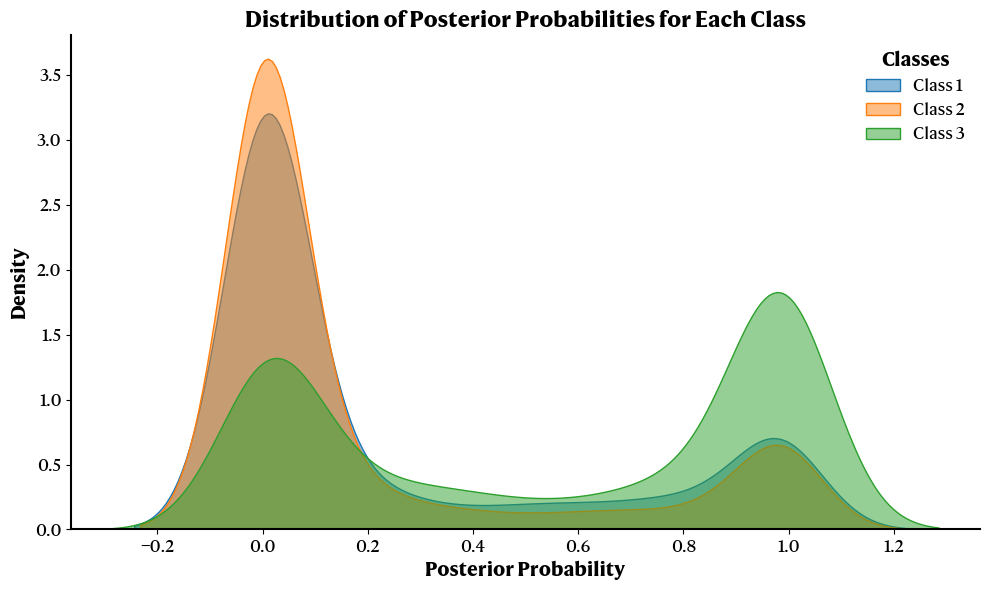

In [ ]:
# Plot the distribution of posterior probabilities for each class using a kde plot.
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(3):
    sns.kdeplot(df_pp_merged[f'probYT{i+1}'], label=f'Class {i+1}', fill=True, alpha=0.5, cmap=cmap)
ax.set_xlabel('Posterior Probability', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Posterior Probabilities for Each Class', fontsize=16, fontweight='bold')
ax.legend(title='Classes', fontsize=12, title_fontproperties={'weight':'bold', 'size': 14}, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1.5)
plt.tight_layout()

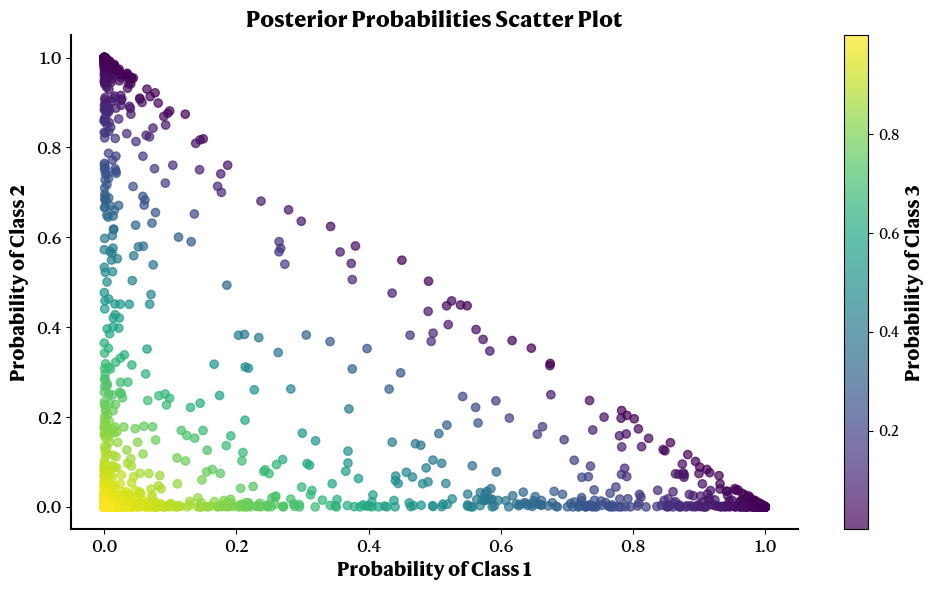

In [60]:
# Now do a scatter plot of posterior probabilities of class 1 vs class 2, colored by class 3 probability.
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_pp_merged['probYT1'], df_pp_merged['probYT2'], c=df_pp_merged['probYT3'], cmap='viridis', alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Probability of Class 3', fontsize=14, fontweight='bold')
ax.set_xlabel('Probability of Class 1', fontsize=14, fontweight='bold')
ax.set_ylabel('Probability of Class 2', fontsize=14, fontweight='bold')
ax.set_title('Posterior Probabilities Scatter Plot', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1.5)
plt.tight_layout()